In [1]:
from brian2 import *
from DynapSE import DynapSE
from Spike_G import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90
from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings/dynapse-simulator-New-Parameters/

BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

Neurons:

1. Excitory neurons make up about 80% of the total neuronal population.
2. Inhibitory neurons make up about 20% of the total neuronal population. 
3. PV neurons (58% inhibitory) are fast-spiking.
4. SST neurons (42% inhibitory)  are low-threshold spiking. 
5. PC neurons (excitatory) are regular spiking.

Synaptic Connectivities: 

6. PC are highly interconnected (25% to 36% of connectivity probabilities). 
7. SST and PV cells connect to at least half, or even all excitatory cells of the local circuit (> 50% ).
8. Strong inhibition between SST and PC. 
9. PV has recurrent connections. 
10. PC has has Shortterm depression to PV and Short-Term Facilitation to SST

Thalamacortical connections: 

10. Strong connections to PV. (Short-term depression)
11. weak connections to SST. (Short-term facilitation)
12. Constant strength to PC. 





In [5]:
def Network_sim(freq,duration):      
    # to start a new build to run multiple full simulations
    device.reinit()
    device.activate()
    # need to reset the defaultclock after activate
    defaultclock.dt = 20 * us

    # Create a Brian2 network and chip instance using that monitors Dynap-SE1 resources.
    network = Network()
    chip = DynapSE(network)


    # ///////////////////////////// Populations ////////////////////////////////////////////////
    # number neurons
    n = 10
    exc = round(n * 0.8)
    inh = round(n * 0.2)
    n_PC = exc 
    n_SST = round(inh * 0.42)
    n_PV = round(inh * 0.58)

    # define the populations of neurons
    PC = chip.get_neurons(n_PC, 'Core_1')
    SST = chip.get_neurons(n_SST, 'Core_2')
    PV = chip.get_neurons(n_PV, 'Core_3')

    
    # ///////////////////////////// Freqiiecy Input to PC ////////////////////////////////////////////////
    spikegen = SpikeGen('regular',0,1,1,freq,1,'SpikeGenerator')



    # ///////////////////////////// CONNECTIONS ////////////////////////////////////////////////

    # Synapses, Thalamacortical Connections
    syn_inpPC = chip.add_connection(spikegen, PC, synapse_type='AMPA')
    chip.connect(syn_inpPC,True)
    syn_inpPV = chip.add_connection(spikegen, PV, synapse_type='AMPA')
    chip.connect(syn_inpPV,True)
    syn_inpSST = chip.add_connection(spikegen, SST, synapse_type='AMPA')
    chip.connect(syn_inpSST,True)

    # set Thalamacortical weights
    syn_inpPC.weight = 300
    syn_inpPV.weight = 200
    syn_inpSST.weight = 600

    # Synapses, Local Connections
    syn_PC = chip.add_connection(PC, PC, synapse_type='NMDA')
    syn_PC.connect(p=0.30)
    syn_PV = chip.add_connection(PV, PV, synapse_type='GABA_B')
    chip.connect(syn_PV,True)

    syn_SSTPC = chip.add_connection(SST, PC, synapse_type='GABA_B')
    syn_SSTPC.connect(p=0.8)
    syn_PVPC = chip.add_connection(PV, PC, synapse_type='GABA_B')
    syn_PVPC.connect(p=0.8)

    syn_PCSST = chip.add_connection(PV, SST, synapse_type='NMDA')
    chip.connect(syn_PCSST,True)
    syn_PCPV = chip.add_connection(PC, PV, synapse_type='NMDA')
    chip.connect(syn_PCPV,True)

    syn_PVSST = chip.add_connection(PV, SST, synapse_type='GABA_B')
    chip.connect(syn_PVSST,True)
    syn_SSTPV = chip.add_connection(SST, PV, synapse_type='GABA_B')
    chip.connect(syn_SSTPV,True)

    # set Local connection weights
    syn_PC.weight = 300
    syn_PV.weight = 300
    syn_SSTPC.weight = 600
    syn_PVPC.weight = 300
    syn_PCSST.weight = 600
    syn_PCPV.weight = 100
    syn_PVSST.weight = 100
    syn_SSTPV.weight = 100

    # apply conditions
    


    # set the params

    # Monitors
    #mon_neuron_input  = SpikeMonitor(spikegen, name='mon_neuron_input')
    SST_output = SpikeMonitor(SST, name='SST_output')
    #mon_adapt_state  = StateMonitor(SST,  'Iahp', record=True)
    #mon_mem_state  = StateMonitor(SST,  'Imem', record=True)


    network.add([spikegen,PC,SST,PV,syn_inpPC,syn_inpPV,syn_inpSST,syn_PC,syn_PV,syn_SSTPC,syn_PVPC,syn_PCSST,syn_PCPV,syn_PVSST,syn_SSTPV,SST_output])

    # Simulation
    network.run(duration * 1000 * ms)


    print(SST_output.t)

    return SST_output

In [6]:
def remove_last_element(arr):
    return arr[np.arange(arr.size - 1)]

In [7]:

freq_list=[200,300]*Hz
duration=1


output_rates=[]

# Connect a single spike generator to a single DPI neuron 
for i in freq_list:
    output_rates.append(Network_sim(i,duration))
    


8 neurons are allocated from Core_1.
1 neurons are allocated from Core_2.
1 neurons are allocated from Core_3.


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
make.deps:636: *** missing separator.  Stop.


RuntimeError: Project compilation failed (error code: 512). Consider running with "clean=True" to force a complete rebuild.

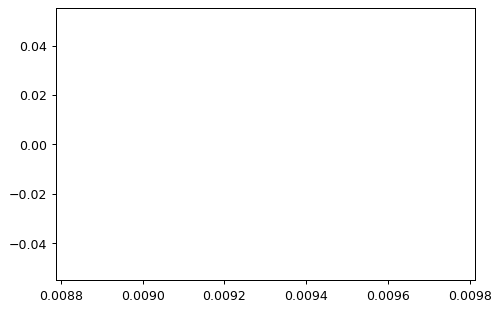

In [13]:
plot(output_rates[1].t,output_rates[1].i,'k')

In [1]:
## Declare possible values taken by your variables e..g

PC_Itau= [1,2,3,4]
SST_Itau = [10,20,30,40]
SST_Itauahp = [10,20,30,40]
SST_I = [10,20,30,40]

results_dictionary = {} ## Initialize our dictionary

parameters_memory = []

condition_satisfied = False


n_iter = 1000 ## How many run throughs you'd like to do.

for i in range(n_iter):

    results_dictionary[iter] = {} ## Initialize the second level of our dictionary

    while condition_satisfied == False: 
        local_x = random.sample(PC_Itau, 3)

        ## Verify that your random sample satisfies your conditions. Dummy example:
        if local_x > 2*local_y and [local_x, local_y] not in parameters_memory: 
            ## Condition is satisfied and our parameter sample is new
            condition_satisfied = True

    ## Once we exited our while loop (we have a combination of parameters that satisfy our 
    #     constraints and are never seen before), we execute whatever thing we want to execute 

    parameters_memory.append([local_x, local_y])

    performance = do_something_cool(local_x, local_y)

    PV_conf = {"Itau": 50 * pA}

    SST_conf = {"Itauahp": 0.03 * pA,            
                "Ithahp": 0.06 * pA,
                "Ispkthr": 0.5 * nA # low threhsold spiking
            }

    Network_sim(duration,SST_conf,PV_conf)

    
    ## Save perf for our parameters
    results_dictionary[iter]['X'] = local_x
    results_dictionary[iter]['Y'] = local_y
    results_dictionary[iter]['Performance'] = performance

    condition_satisfied = False # set it back to false so we check at the next iteration



## Save dictionary with results
filename_ = 'noise_is_a_feature.csv'
df = pd.DataFrame(results_dictionary)
df.to_csv(filename_, index=False, header=None)

NameError: name 'random' is not defined